### Importy i ścieżki

In [2]:
import json
from pathlib import Path
from typing import Dict, Any, Tuple, List
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.chdir('../..')
print("Working directory:", os.getcwd())

json_50 = Path("results/AudioLIME/FakeRealMusicOriginal/FULL_TEST/full_track/explanations.json")
json_500 = Path("results/AudioLIME/FakeRealMusicOriginal/FULL_TEST_500/full_track/explanations.json")

json_minus14_500 = Path('results/AudioLIME/FakeRealMusicOriginalNormalized/minus14/base/FULL_TEST_500/full_track/explanations.json')
json_minus23_500 = Path('results/AudioLIME/FakeRealMusicOriginalNormalized/minus23/base/FULL_TEST_500/full_track/explanations.json')


Working directory: c:\0. Studia\Magisterka\Praca magisterska\Experiments


###  Wczytanie i normalizacja

In [ ]:
def load_json(p: Path) -> Dict[str, Any]:
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)

DEFAULT_COMPONENTS = ["vocals0",'piano0', 'drums0','bass0','other0']

def to_long_frame(data: Dict[str, Any], run_label: str) -> pd.DataFrame:
    rows = []
    for model_name, items in data.items():
        if not isinstance(items, dict):
            continue
        for file_name, results in items.items():
            file_path = results.get('explanations').get('file_path')
            comp = results.get('explanations').get('component_influences', {})
            if comp:
                it = comp.items()
            else:
                it = [(c, np.nan) for c in DEFAULT_COMPONENTS]
            for k, v in it:
                rows.append({
                    "data_source": model_name,
                    "file_path": file_path,
                    "file_name": file_name,
                    "file_index": int(results.get('track_id')),
                    "component": k,
                    "value": (float(v) if v is not np.nan else np.nan),
                    "run": run_label
                })
    return pd.DataFrame(rows)

data_50 = load_json(json_500)
data_500 = load_json(json_minus14_500)

legend_name1 = "base_lime500"
legend_name2 = "m14_lime500"

df50 = to_long_frame(data_50, legend_name1)
df500 = to_long_frame(data_500, legend_name2)

df = pd.concat([df50, df500], ignore_index=False)
df.head()


,data_source,file_path,file_name,file_index,component,value,run
0,ElevenLabs,Data\FakeRealMusicOriginal\ElevenLabs\10._Adel...,10__Adele_Rolling_in_the_Deep_-_Edge_of_the_He...,1,vocals0,0.613789,base_lime500
1,ElevenLabs,Data\FakeRealMusicOriginal\ElevenLabs\10._Adel...,10__Adele_Rolling_in_the_Deep_-_Edge_of_the_He...,1,drums0,0.034756,base_lime500
2,ElevenLabs,Data\FakeRealMusicOriginal\ElevenLabs\10._Adel...,10__Adele_Rolling_in_the_Deep_-_Edge_of_the_He...,1,bass0,0.009291,base_lime500
3,ElevenLabs,Data\FakeRealMusicOriginal\ElevenLabs\10._Adel...,10__Adele_Rolling_in_the_Deep_-_Edge_of_the_He...,1,other0,-0.095156,base_lime500
4,ElevenLabs,Data\FakeRealMusicOriginal\ElevenLabs\3._Imagi...,3__Imagine_Dragons_Believer_-_Together_We_Rise...,3,vocals0,0.485165,base_lime500


### Filtering

In [37]:
keys_50 = df50[["data_source","file_name","component"]].drop_duplicates()
keys_500 = df500[["data_source","file_name","component"]].drop_duplicates()

common = keys_50.merge(keys_500, on=["data_source","file_name","component"], how="inner")

df_common = df.merge(common, on=["data_source","file_name","component"], how="inner")
df_common = df_common.sort_values(["data_source","component","file_index","run"]).reset_index(drop=True)

df_common.head(10)
df_common.query('data_source == "REAL"').sort_values(['file_index','component','run']).head(100)


,data_source,file_path,file_name,file_index,component,value,run
80,REAL,Data\FakeRealMusicOriginal\REAL\Adele_RollingI...,Adele_RollingInTheDeep_mp3,0,bass0,0.063874,base_lime500
81,REAL,Data\FakeRealMusicOriginalNormalized\minus14\b...,Adele_RollingInTheDeep_mp3,0,bass0,0.026164,m14_lime500
100,REAL,Data\FakeRealMusicOriginal\REAL\Adele_RollingI...,Adele_RollingInTheDeep_mp3,0,drums0,0.210630,base_lime500
101,REAL,Data\FakeRealMusicOriginalNormalized\minus14\b...,Adele_RollingInTheDeep_mp3,0,drums0,0.223044,m14_lime500
120,REAL,Data\FakeRealMusicOriginal\REAL\Adele_RollingI...,Adele_RollingInTheDeep_mp3,0,other0,-0.305598,base_lime500
...,...,...,...,...,...,...,...
119,REAL,Data\FakeRealMusicOriginalNormalized\minus14\b...,TravisScott_SICKOMODE_mp3,9,drums0,0.144717,m14_lime500
138,REAL,Data\FakeRealMusicOriginal\REAL\TravisScott_SI...,TravisScott_SICKOMODE_mp3,9,other0,-0.210000,base_lime500
139,REAL,Data\FakeRealMusicOriginalNormalized\minus14\b...,TravisScott_SICKOMODE_mp3,9,other0,-0.232775,m14_lime500
158,REAL,Data\FakeRealMusicOriginal\REAL\TravisScott_SI...,TravisScott_SICKOMODE_mp3,9,vocals0,0.333194,base_lime500


### Plots per-provider and per-komponent

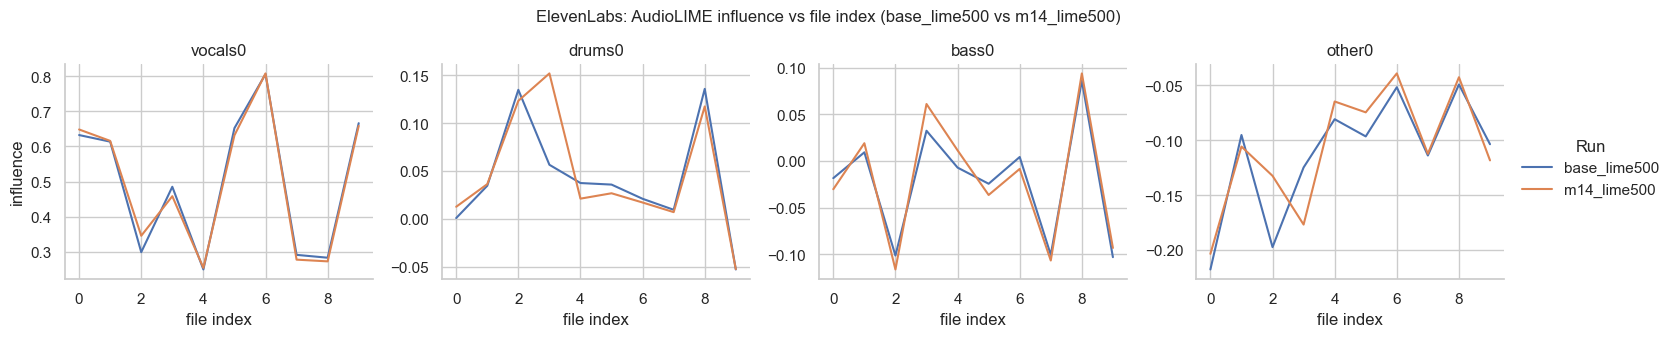

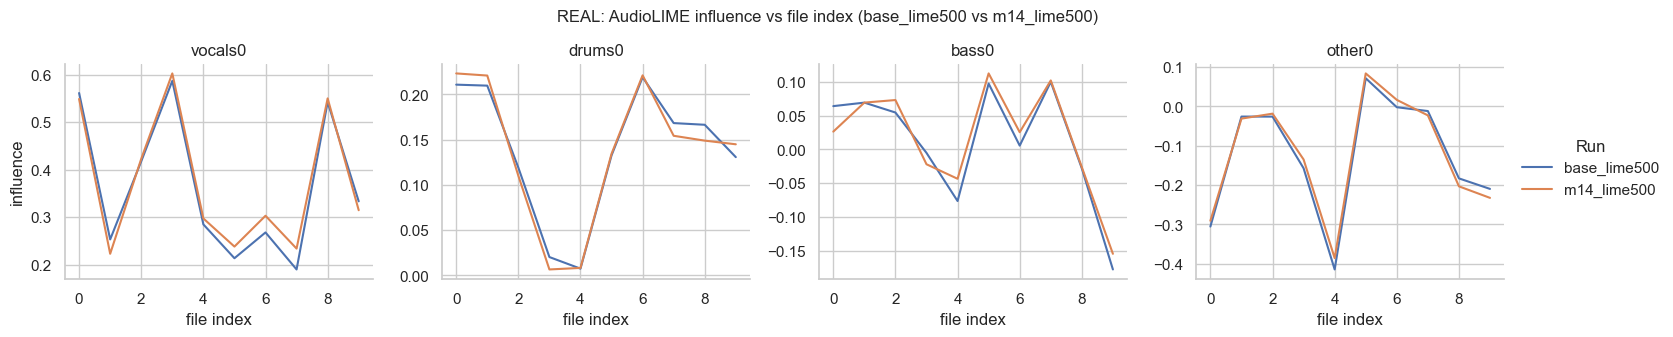

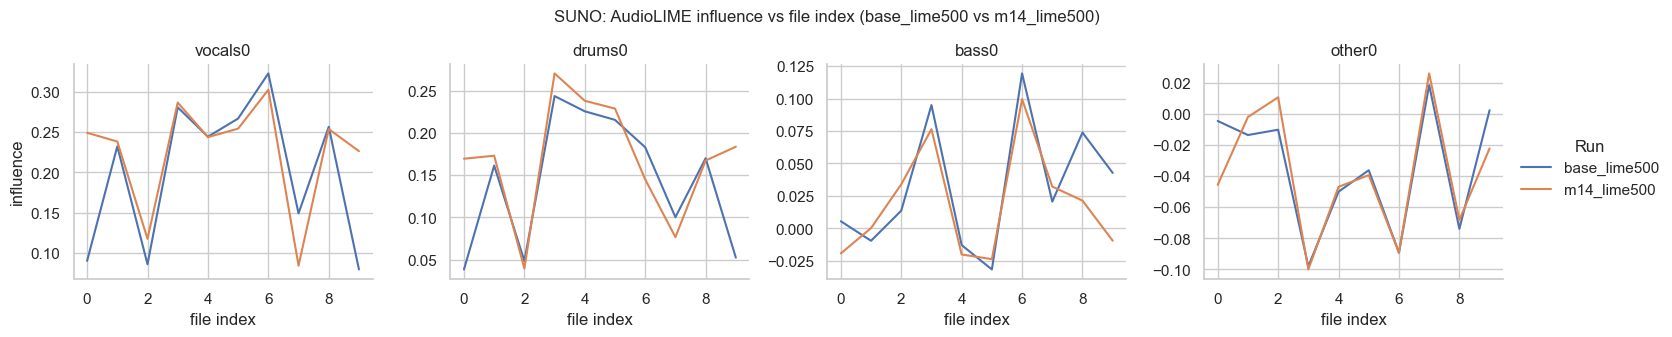

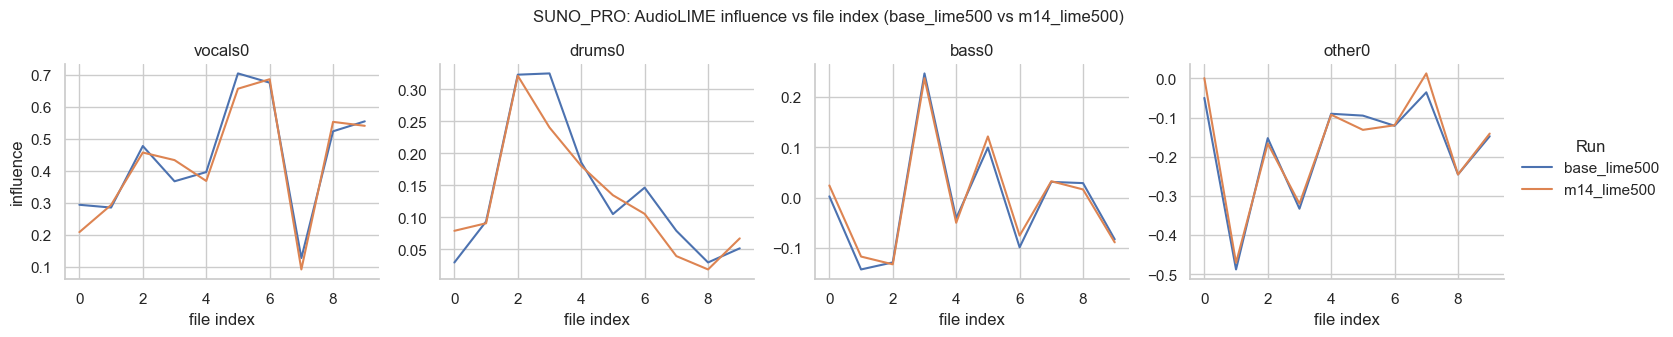

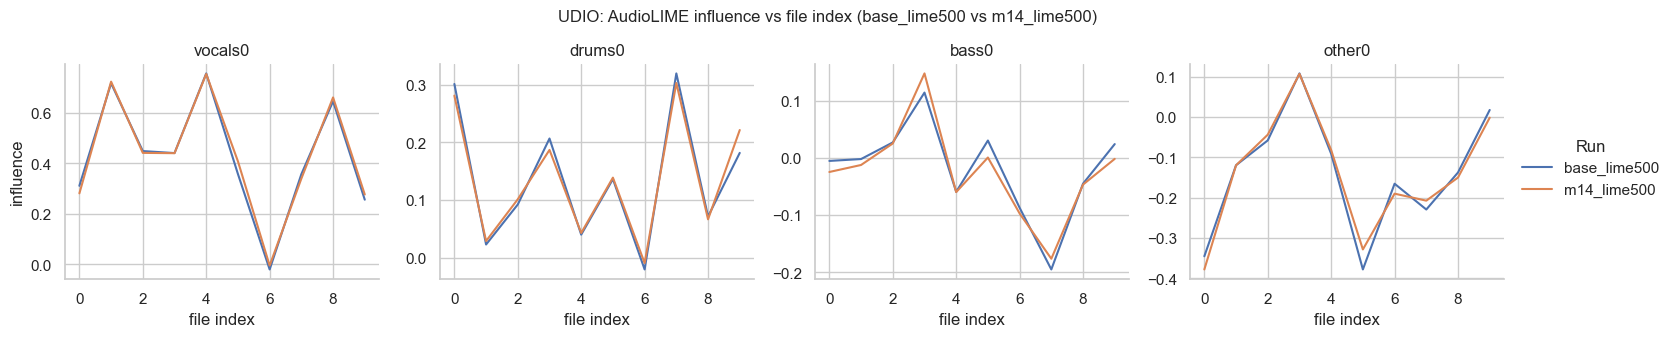

In [39]:
sns.set_theme(style="whitegrid")

providers = sorted(df_common["data_source"].unique())
components_order = ["vocals0","piano0","drums0","bass0","other0"]

for prov in providers:
    dprov = df_common[df_common["data_source"] == prov].copy()
    if dprov.empty:
        continue
    comps = [c for c in components_order if c in dprov["component"].unique()]
    if not comps:
        continue

    g = sns.FacetGrid(
        dprov[dprov["component"].isin(comps)],
        col="component",
        col_order=comps,
        hue="run",
        height=3.2,
        aspect=1.2,
        sharey=False
    )
    g.map_dataframe(sns.lineplot, x="file_index", y="value")
    g.add_legend(title="Run")
    g.set_axis_labels("file index", "influence")
    g.set_titles(col_template="{col_name}")
    g.fig.suptitle(f"{prov}: AudioLIME influence vs file index ({legend_name1} vs {legend_name2})", y=1.05, fontsize=12)
    plt.show()


### Scatter influence_50 vs influence_500

In [40]:
pivot = df_common.pivot_table(
    index=["data_source","file_name","file_index","component"],
    columns="run",
    values="value",
    aggfunc="mean"
).reset_index()

pivot = pivot.dropna(subset=[legend_name1,legend_name2])
providers = sorted(pivot["data_source"].unique())
components_order = ["vocals0","piano0","drums0","bass0","other0"]


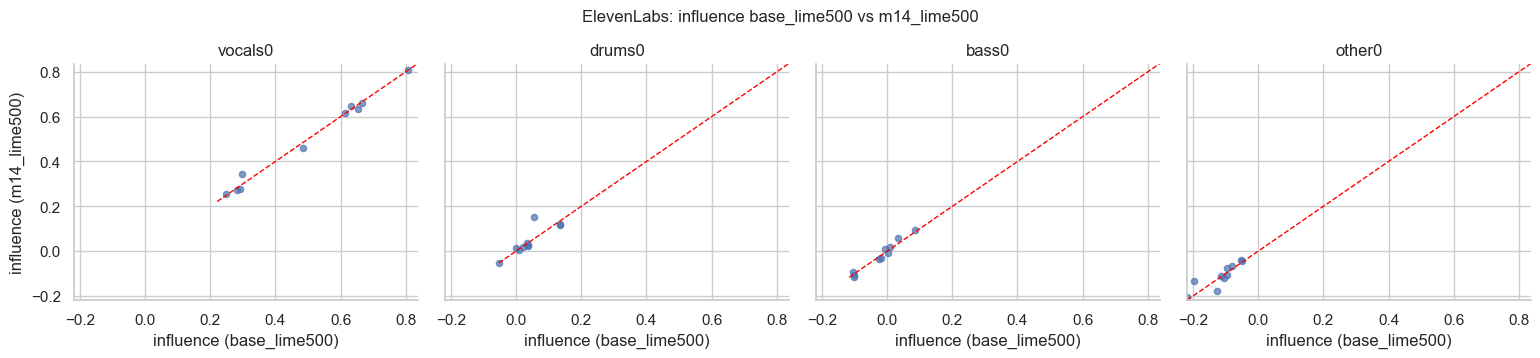

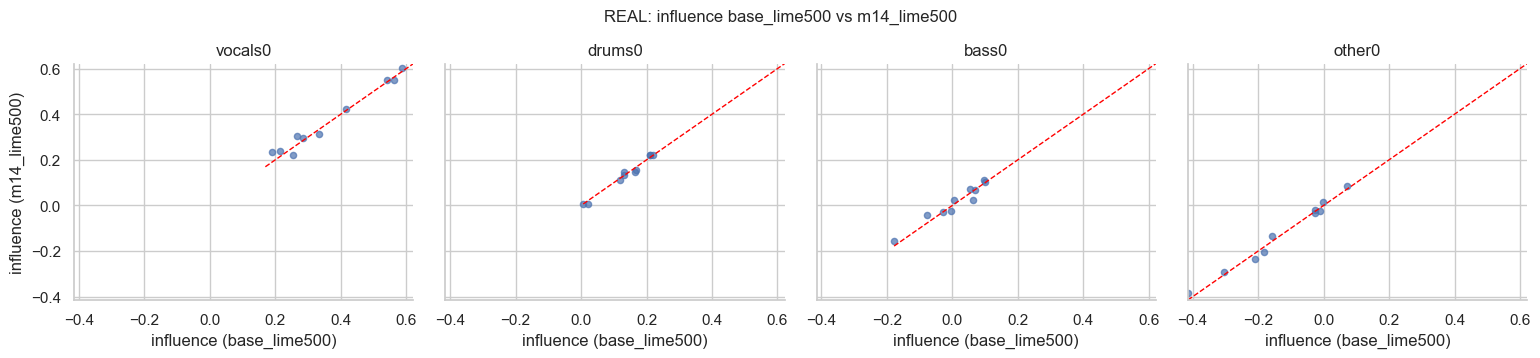

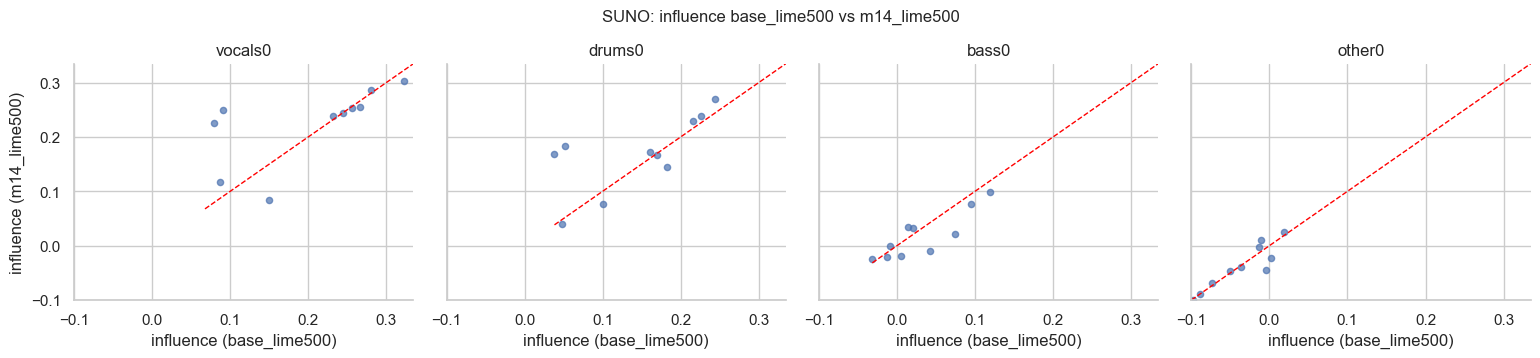

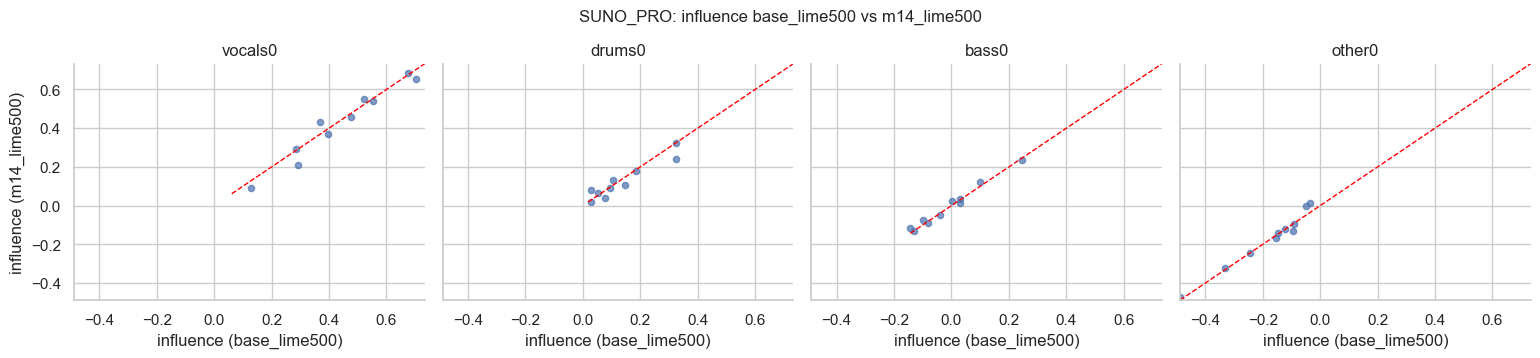

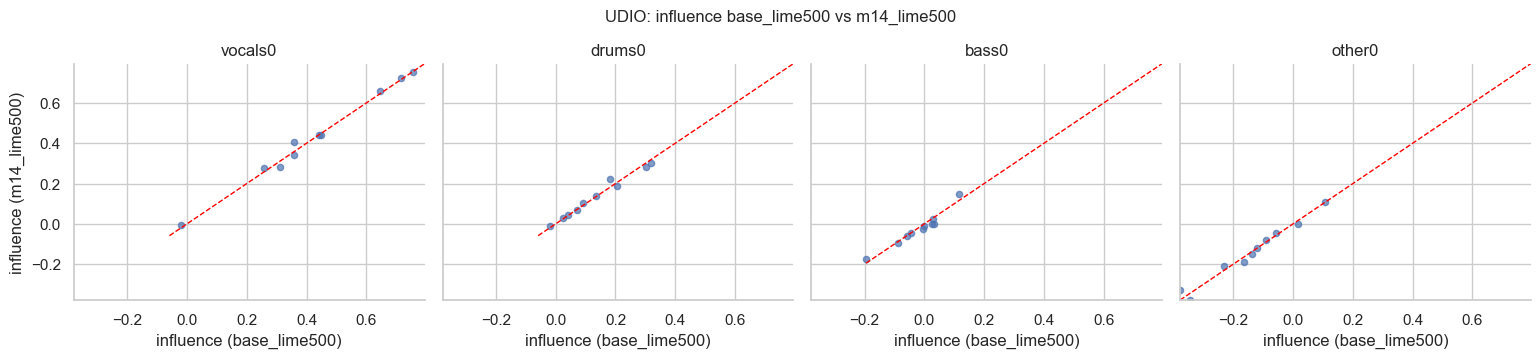

In [47]:
for prov in providers:
    pprov = pivot[pivot["data_source"] == prov].copy()
    if pprov.empty:
        continue
    comps = [c for c in components_order if c in pprov["component"].unique()]
    if not comps:
        continue

    g = sns.FacetGrid(
        pprov[pprov["component"].isin(comps)],
        col="component",
        col_order=comps,
        height=3.2,
        aspect=1.2,
        sharex=True,
        sharey=True
    )

    def _scatter(data, color=None, **kwargs):
        ax = plt.gca()
        ax.scatter(data[legend_name1], data[legend_name2], s=20, alpha=0.7)

        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()

        dmin_x = float(data[legend_name1].min()) if len(data) else x0
        dmax_x = float(data[legend_name1].max()) if len(data) else x1
        dmin_y = float(data[legend_name2].min()) if len(data) else y0
        dmax_y = float(data[legend_name2].max()) if len(data) else y1

        lim_min = min(x0, y0, dmin_x, dmin_y)
        lim_max = max(x1, y1, dmax_x, dmax_y)

        ax.plot([lim_min, lim_max], [lim_min, lim_max], ls="--", c="red", lw=1)
        ax.set_xlim(lim_min, lim_max)
        ax.set_ylim(lim_min, lim_max)

    g.map_dataframe(_scatter)
    g.set_axis_labels(f"influence ({legend_name1})", f"influence ({legend_name2})")
    g.set_titles(col_template="{col_name}")
    g.fig.suptitle(f'{prov}: influence {legend_name1} vs {legend_name2}', y=1.05, fontsize=12)
    plt.show()


###  Metrics

In [45]:
pivot["diff"] = pivot[legend_name2] - pivot[legend_name1]
pivot["abs_diff"] = pivot["diff"].abs()

summary = (
    pivot.groupby(["data_source","component"], as_index=False)["abs_diff"]
    .mean()
    .rename(columns={"abs_diff":"mean_abs_diff"})
    .sort_values(["data_source","mean_abs_diff"], ascending=[True, False])
)
summary.head(20)


,data_source,component,mean_abs_diff
2,ElevenLabs,other0,0.021520
1,ElevenLabs,drums0,0.017076
3,ElevenLabs,vocals0,0.015043
0,ElevenLabs,bass0,0.013213
7,REAL,vocals0,0.020655
4,REAL,bass0,0.016785
6,REAL,other0,0.016353
5,REAL,drums0,0.009664
11,SUNO,vocals0,0.044959
9,SUNO,drums0,0.039984


### Heatmaps

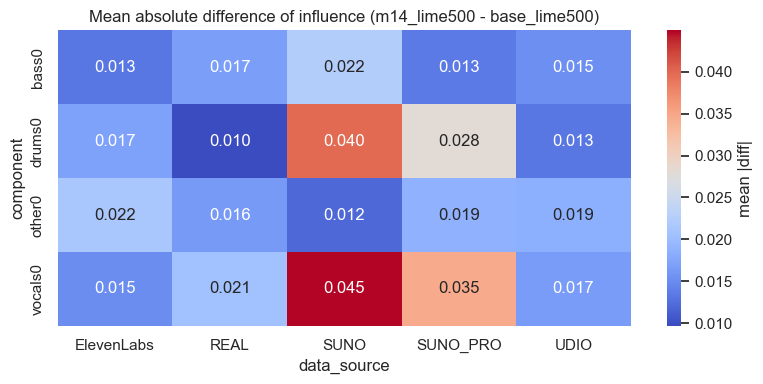

In [46]:
heat = summary.pivot(index="component", columns="data_source", values="mean_abs_diff")
plt.figure(figsize=(8,4))
sns.heatmap(heat, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={"label":"mean |diff|"})
plt.title(f"Mean absolute difference of influence ({legend_name2} - {legend_name1})")
plt.xlabel("data_source")
plt.ylabel("component")
plt.tight_layout()
plt.show()
